In [44]:
%matplotlib inline
from matplotlib import style
style.use('seaborn-darkgrid')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, desc

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [10]:
# Display the row's columns and data in dictionary format
first_row = session.query(Station).first()
first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x200ac27bfd0>,
 'id': 1,
 'elevation': 3.0,
 'latitude': 21.2716,
 'name': 'WAIKIKI 717.2, HI US',
 'longitude': -157.8168,
 'station': 'USC00519397'}

In [11]:
# Display the row's columns and data in dictionary format
first_rowM = session.query(Measurement).first()
first_rowM.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x200ac2cbba8>,
 'prcp': 0.08,
 'station': 'USC00519397',
 'tobs': 65.0,
 'date': '2010-01-01',
 'id': 1}

In [12]:
# Create Last Date Information
last_date = session.query(Measurement.date).\
   order_by(Measurement.date.desc()).first().date
last_date

'2017-08-23'

In [26]:
# Create Past 12 Month Date
past12mth_date = dt.date(2017, 8, 23) - dt.timedelta(days=365)
past12mth_date

datetime.date(2016, 8, 23)

C:\Users\mldeb\Anaconda3\lib\site-packages\pandas\plotting\_core.py:185: UserWarning: 'colors' is being deprecated. Please use 'color'instead of 'colors'
  warnings.warn(("'colors' is being deprecated. Please use 'color'"


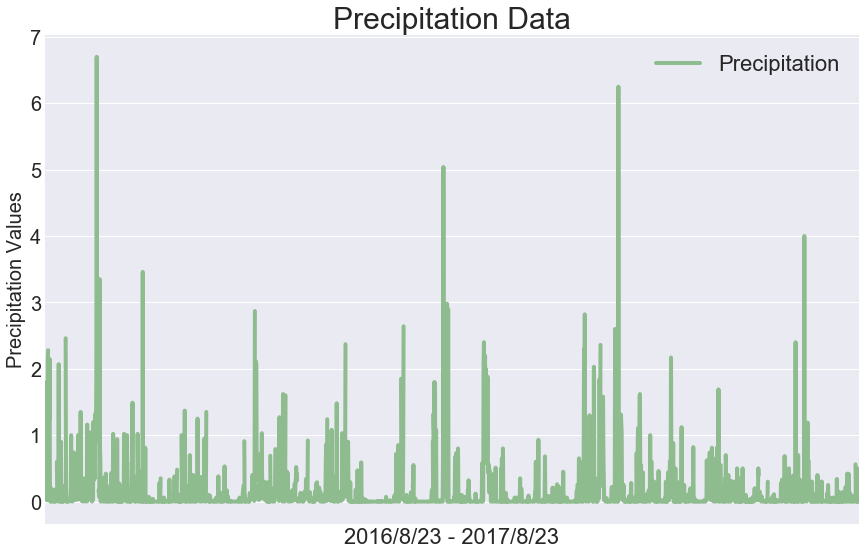

In [159]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# Calculate the date 1 year ago from the last data point in the database
# Perform a query to retrieve the data and precipitation scores
query = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= past12mth_date).all()
query1 = pd.DataFrame(query, columns=['Date', 'Precipitation'])
query2 = query1.set_index('Date')

# Save the query results as a Pandas DataFrame and set the index to the date column
query3 = query2.sort_values('Date')

# Use Pandas Plotting with Matplotlib to plot the data
colors = ["darkseagreen"]
query3.plot(x_compat=True, figsize=(13,9), colors=colors)
plt.xticks([], [])
plt.yticks(fontsize = 20)
plt.xlabel('2016/8/23 - 2017/8/23',fontsize=22)
plt.legend(fontsize=22)
plt.title('Precipitation Data',fontsize=30)
plt.ylabel("Precipitation Values", fontsize=20)

# Save Png
plt.savefig('Images/precipitation2.png')

In [15]:
# Use Pandas to calcualte the summary statistics for the precipitation data
query3.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [16]:
# Design a query to show how many stations are available in this dataset?
total_stations = session.query(func.count(Station.station)).all()
total_stations

[(9)]

In [17]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
stations_count = session.query(Measurement.station, func.count(Measurement.station)).\
group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()
stations_count

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [18]:
# Using the station id from the previous query, calculate the lowest temperature recorded,
# highest temperature recorded, and average temperature of the most active station?
temps = session.query(Measurement.station, Measurement.tobs).all()

# Create Data Frame For Temps
temps = pd.DataFrame(temps, columns=['Station_ID', 'Temp'])
temps = temps.set_index("Station_ID")
temps = temps.loc['USC00519281']

# Retrieve MIN MAX and MEAN
temp_stats = temps.agg({'Temp':['min','max','mean']})
temp_stats

,Temp
min,54.000000
max,85.000000
mean,71.663781


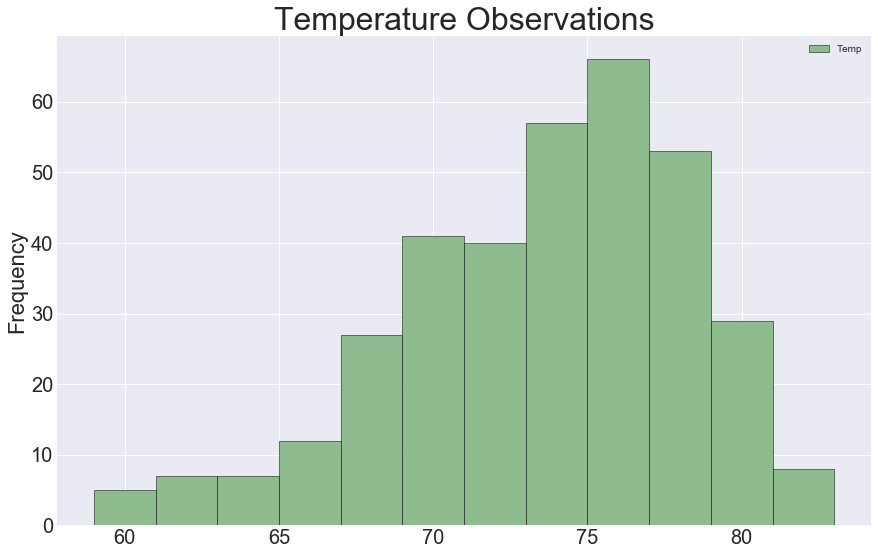

In [145]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temps_12_months = session.query(Measurement.date, Measurement.station, Measurement.tobs).\
filter(Measurement.station=='USC00519281').\
filter(Measurement.date >= past12mth_date).all()

# Create Data Frame For Temps Over a 12 Month Period Of Time
temps_12_months = pd.DataFrame(temps_12_months, columns=['Date', 'Station_ID', 'Temp'])
temps_12_months.plot.hist(bins=12, colors=colors, figsize=(13,9), edgecolor="black")
ax.set_facecolor("blue")
plt.title("Temperature Observations", fontsize = 32)
plt.yticks(fontsize = 20)
plt.ylabel('Frequency',fontsize=22)
plt.xticks(fontsize = 20)

# Save Png
plt.savefig('Images/station-histogram2.png')

In [41]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [49]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
previous_year = calc_temps('2016-8-23', '2017-08-23')


In [50]:
# Create Data Frame For plot
year_temp = pd.DataFrame(previous_year, columns=["Min", "Avg", "Max"])
year_temp.head()

,Min,Avg,Max
0,58.0,74.14388,87.0


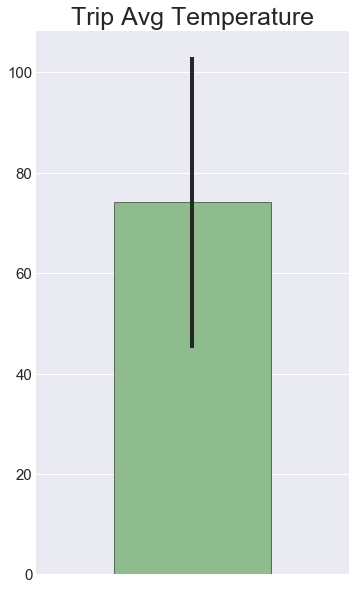

In [106]:
# Plot the results from your previous query as a bar chart for avg.
year_temp["Avg"].plot.bar(yerr=87-58, colors=colors, edgecolor="black", figsize=(5,10))
plt.title("Trip Avg Temperature", fontsize=(25))
plt.yticks(fontsize=(15))
plt.xticks([])
# Save Png
plt.savefig('Images/Trip_AVG_Temp.png')

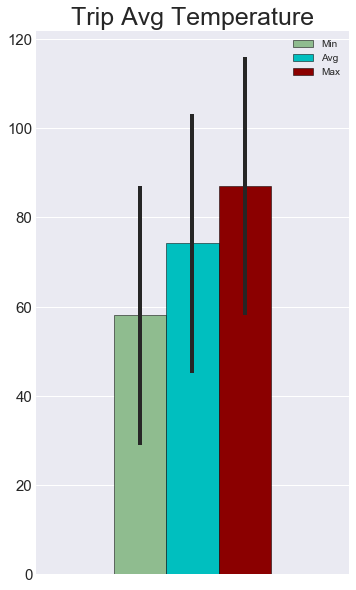

In [107]:
# Plot the results from your previous query as a bar chart. 
colors = ["darkseagreen", "c", "darkred"]
year_temp.plot.bar(yerr=87-58, colors=colors, edgecolor="black", figsize=(5,10))
plt.title("Trip Avg Temperature", fontsize=(25))
plt.yticks(fontsize=(15))
plt.xticks([])
# Save Png
plt.savefig('Images/Trip_AVG_Min_Max_Temp.png')

In [ ]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



## Optional Challenge Assignment

In [74]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
